# EDA Demographique

In [6]:
import polars as pl
import pyarrow.parquet as pq
import sys

filepath = "../Data/processed/sirene_infos.parquet" 

print("--- Début de la lecture 'bypass' ---")

try:
    print(f"Lecture du fichier via PyArrow : {filepath}")
    table_arrow = pq.read_table(
        filepath,
    )
    
    print("Conversion de la table PyArrow en DataFrame Polars...")
    df_demo = pl.from_arrow(table_arrow)
    
    print("--- SUCCÈS ! ---\n")
    print("Le DataFrame est maintenant dans Polars, prêt pour la transformation.")
    print(df_demo.head())

except Exception as e:
    print(f"\n--- ERREUR ---", file=sys.stderr)
    print(f"Impossible de lire le fichier, même avec PyArrow : {e}", file=sys.stderr)

--- Début de la lecture 'bypass' ---
Lecture du fichier via PyArrow : ../Data/processed/sirene_infos.parquet
Conversion de la table PyArrow en DataFrame Polars...
--- SUCCÈS ! ---

Le DataFrame est maintenant dans Polars, prêt pour la transformation.
shape: (5, 15)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ siren     ┆ dateCreat ┆ dateFerme ┆ is_failed ┆ … ┆ moisCreat ┆ departeme ┆ trancheEf ┆ caracter │
│ ---       ┆ ionUniteL ┆ ture      ┆ _in_3y    ┆   ┆ ion       ┆ nt        ┆ fectifsSi ┆ eEmploye │
│ str       ┆ egale     ┆ ---       ┆ ---       ┆   ┆ ---       ┆ ---       ┆ ege       ┆ urSiege  │
│           ┆ ---       ┆ date      ┆ i32       ┆   ┆ i8        ┆ str       ┆ ---       ┆ ---      │
│           ┆ date      ┆           ┆           ┆   ┆           ┆           ┆ str       ┆ str      │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ 000325175 ┆ 2000-09-2 ┆ n

---

# EDA Bilan

In [13]:
import polars as pl
import pyarrow.parquet as pq
import sys

filepath = "../Data/processed/sirene_bilan_EDA.parquet" 

print("--- Début de la lecture 'bypass' ---")

try:
    print(f"Lecture du fichier via PyArrow : {filepath}")
    table_arrow = pq.read_table(
        filepath,
    )
    
    print("Conversion de la table PyArrow en DataFrame Polars...")
    df_bilan = pl.from_arrow(table_arrow)
    
    print("--- SUCCÈS ! ---\n")
    print("Le DataFrame est maintenant dans Polars, prêt pour la transformation.")
    print(df_bilan.head())

except Exception as e:
    print(f"\n--- ERREUR ---", file=sys.stderr)
    print(f"Impossible de lire le fichier, même avec PyArrow : {e}", file=sys.stderr)

--- Début de la lecture 'bypass' ---
Lecture du fichier via PyArrow : ../Data/processed/sirene_bilan_EDA.parquet
Conversion de la table PyArrow en DataFrame Polars...
--- SUCCÈS ! ---

Le DataFrame est maintenant dans Polars, prêt pour la transformation.
shape: (5, 21)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ siren     ┆ date_clot ┆ CJCK_Tota ┆ EG_Impots ┆ … ┆ ratio_cap ┆ ratio_tre ┆ ratio_res ┆ ratio_re │
│ ---       ┆ ure_exerc ┆ lActifBru ┆ Taxes     ┆   ┆ itaux_pro ┆ sorerie   ┆ ultat_fin ┆ sultat_e │
│ str       ┆ ice       ┆ t         ┆ ---       ┆   ┆ pres      ┆ ---       ┆ ancier    ┆ xception │
│           ┆ ---       ┆ ---       ┆ i32       ┆   ┆ ---       ┆ f64       ┆ ---       ┆ nel      │
│           ┆ date      ┆ i32       ┆           ┆   ┆ f64       ┆           ┆ f64       ┆ ---      │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆ f64      │
╞═══════════╪══════════

In [14]:
df_bilan.schema

Schema([('siren', String),
        ('date_cloture_exercice', Date),
        ('CJCK_TotalActifBrut', Int32),
        ('EG_ImpotsTaxes', Int32),
        ('FJ_ResultatFinancier', Int32),
        ('FA_ChiffreAffairesVentes', Int32),
        ('HN_RésultatNet', Int32),
        ('DA_TresorerieActive', Int32),
        ('DL_DettesCourtTerme', Int32),
        ('FB_AchatsMarchandises', Int32),
        ('FR_ResultatExceptionnel', Int32),
        ('DF_CapitauxPropres', Int32),
        ('DM_DettesLongTerme', Int32),
        ('AnneeClotureExercice', Int32),
        ('ratio_rentabilite_nette', Float64),
        ('ratio_endettement', Float64),
        ('ratio_marge_brute', Float64),
        ('ratio_capitaux_propres', Float64),
        ('ratio_tresorerie', Float64),
        ('ratio_resultat_financier', Float64),
        ('ratio_resultat_exceptionnel', Float64)])

🚀 Plan Détaillé de l'Exploratory Data Analysis (EDA) : eda.ipynb

Ce plan d'EDA a pour objectif de justifier les choix de features et de modélisation pour la prédiction du Résultat Net à un an, en se basant sur l'ensemble d'entraînement ($T=2018$ pour prédire $Y=2019$)

## 1. 📝 Introduction et Structuration de l'AnalyseCette section assure la conformité du projet en termes de contexte business et de qualité du jeu de données

Section Objectif / (Exigence du Projet) / Livrable

1.1 Contexte & BUCDéfinir clairement le défi commercial : Prédiction du Résultat Net à $T+1$2.Texte.

1.2 Description du DatasetConfirmer l'utilisation d'un jeu de données issu d'un scénario réel 3 et sa structure après nettoyage (SIRENs complets 2017-2020).Affichage de df_filtre.shape et df_filtre.dtypes.

1.3 Définition de l'ÉchantillonIsoler l'ensemble d'entraînement pour l'EDA : Features 2018 ($T$) & Cible 2019 ($Y_{T+1}$).Affichage de X_train.shape et y_train.shape.

## 2. 🎯 Analyse Univariée de la Cible ($Y$) : La PrédictionL'analyse de la cible est prioritaire pour choisir la bonne technique de modélisation (régression)

Section / Analyse Visualisation & Justification

2.1 Statistiques DescriptivesCaractériser la distribution de la cible (cible_ResultatNet_T_plus_1) : Moyenne, Médiane, Min, Max.Tableau de statistiques descriptives.

2.2 Distribution et OutliersÉvaluer l'asymétrie de la cible. Les données financières sont typiquement très asymétriques.Histogramme (avec échelle log sur Y pour gérer la forte asymétrie).

2.3 TransformationProposer le traitement des outliers et justifier l'utilisation potentielle d'une transformation (ex: $\ln(1+Y)$) pour normaliser la cible et améliorer les performances du modèle de régression.Box Plot (pour visualiser les valeurs extrêmes).

## 3. 📉 Analyse Bivariée : Sélection des Features (Rigueur Data Science)

Le but est de déterminer quelles features (valeurs $T$, ratios $T$, ou deltas $T$ vs $T-1$) sont les plus prédictives5.SectionAnalyseVisualisation & Justification

3.1 Matrice de CorrélationCalculer la corrélation de Pearson entre la cible $Y_{2019}$ et toutes les features candidates.Heatmap de la matrice de corrélation.

3.2 Validation du Feature EngineeringComparer la corrélation des Deltas (delta_CA, delta_ResultatNet) avec la corrélation des valeurs absolues ($T$). Justifier le choix des deltas.Affichage des coefficients de corrélation les plus élevés (Top 5).

3.3 Corrélation Clé (CA)Illustrer la relation la plus forte (ex: delta_CA vs $Y_{T+1}$) pour montrer la tendance.Scatter Plot (Diagramme de dispersion).

## 4. 🧹 Qualité des Données et Pre-Processing (Meilleures Pratiques)
Cette section garantit la qualité des artefacts de ML666.SectionAnalyseImplication pour le ML

4.1 Valeurs Extrêmes des FeaturesDétecter les entreprises avec des actifs/CA aberrants (FA_ChiffreAffairesVentes, CJCK_TotalActifBrut).Décision d'appliquer une Standardisation/Normalisation pour les modèles sensibles aux échelles.

4.2 Gestion des Zéros/InfIdentifier les cas où les ratios deviennent $\pm \infty$ ou NaN (ex: division par 0 du CA).Justification d'une imputation ou de l'exclusion des ratios problématiques dans le Pre-Processing.5. 📝 Conclusion et Plan d'ExpérimentationCette section sert de pont vers l'implémentation dans main.py et définit la stratégie d'itération et de suivi.SectionSynthèse et Plan d'ActionExigence du Projet

## 5. Synthèse de la PrédictionRésumer les features sélectionnées (basées sur les corrélations).

Justification Data Science.

5.1 Synthèse de la Prédiction	Résumer les features sélectionnées (basées sur les corrélations).	Justification Data Science.

5.2 Proposition de BaselineDéfinir le modèle simple initial (ex: Régression Linéaire) et les features minimales à utiliser7.Baseline Obligatoire8.

5.3 Plan d'ExpérimentationDéfinir les premières étapes d'itération (ajout des Deltas, changement de modèle non-linéaire) et l'importance du suivi des métriques.Experimentation Tracking999999999.

---

# 💻 Étape 1 : Chargement et Préparation des Données

Ce bloc doit être le tout premier dans votre eda.ipynb et garantit que votre fichier est bien chargé et enrichi des colonnes nécessaires (Deltas et Cible $Y_{T+1}$).

In [21]:
import polars as pl
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Configuration visuelle
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
plt.style.use('ggplot')

# --- 1. Chargement du fichier ---
# REMPLACEZ CE CHEMIN PAR LE CHEMIN EXACT DE VOTRE FICHIER PROCESSED/sirene_bilan_EDA.parquet
FILE_PATH = "../Data/processed/sirene_bilan_EDA.parquet" 

try:
    df_bilan_filtre_pl = pl.read_parquet(FILE_PATH)
except Exception as e:
    print(f"ERREUR CRITIQUE : Impossible de charger le fichier Parquet à l'adresse spécifiée. Vérifiez le chemin : {FILE_PATH}")
    print(f"Détails de l'erreur : {e}")
    # Arrêt du script si le chargement échoue
    raise

# Assurez-vous d'avoir trié pour que shift() fonctionne
df_bilan_filtre_pl = df_bilan_filtre_pl.sort(["siren", "AnneeClotureExercice"]) 
cible_col = "cible_HN_RésultatNet_T_plus_1"

# --- 2. Application du Feature Engineering (création des colonnes nécessaires à l'analyse) ---
df_features_pl = df_bilan_filtre_pl.with_columns([
    # Cible Y (Résultat Net à T+1)
    pl.col("HN_RésultatNet").shift(-1).over("siren").alias(cible_col),

    # Deltas (Variation T vs T-1)
    (pl.col("HN_RésultatNet") - pl.col("HN_RésultatNet").shift(1).over("siren")).alias("delta_ResultatNet"),
    (pl.col("FA_ChiffreAffairesVentes") - pl.col("FA_ChiffreAffairesVentes").shift(1).over("siren")).alias("delta_CA"),
    (pl.col("CJCK_TotalActifBrut") - pl.col("CJCK_TotalActifBrut").shift(1).over("siren")).alias("delta_Actif"),
])

# --- 3. Isolation de l'ensemble d'entraînement pour l'EDA (T=2018 pour Y=2019) ---
df_train_pl = df_features_pl.filter(pl.col("AnneeClotureExercice") == 2018)
df_train_pd = df_train_pl.to_pandas() # Conversion pour les outils de visualisation

stats_cible = df_train_pd[cible_col].describe()
nombre_lignes = df_train_pd.shape[0]

print(f"✅ Dataframe d'entraînement (2018 -> 2019) chargé et enrichi. Taille: {nombre_lignes} lignes.")

✅ Dataframe d'entraînement (2018 -> 2019) chargé et enrichi. Taille: 286323 lignes.


# 📊 Étape 2 : Analyse de la Structure Globale (Introduction)

Ce bloc calcule et visualise les tendances générales sur la période 2017-2020.

--- Statistiques Agrégées BRUTES (Inspection du problème 2017/2020) ---
|   AnneeClotureExercice |   Nombre_Bilans |   CA_Total_BRUT |   ResultatNet_Total_BRUT |
|-----------------------:|----------------:|----------------:|-------------------------:|
|                   2017 |          286323 |      1116894349 |                 13032560 |
|                   2018 |          286323 |       381530429 |               1103036097 |
|                   2019 |          286323 |      1894412164 |               1917235483 |
|                   2020 |          286323 |      1035133878 |               -277520704 |
----------------------------------------------------------------------
SI CA_Total_BRUT est proche de zéro en 2017/2020, il y a un problème de donnée ou de filtrage.


/var/folders/sp/97__4mlj3nbc2fssvlgn3_nh0000gn/T/ipykernel_43252/70682179.py:26: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  pl.count().alias("Nombre_Bilans"),


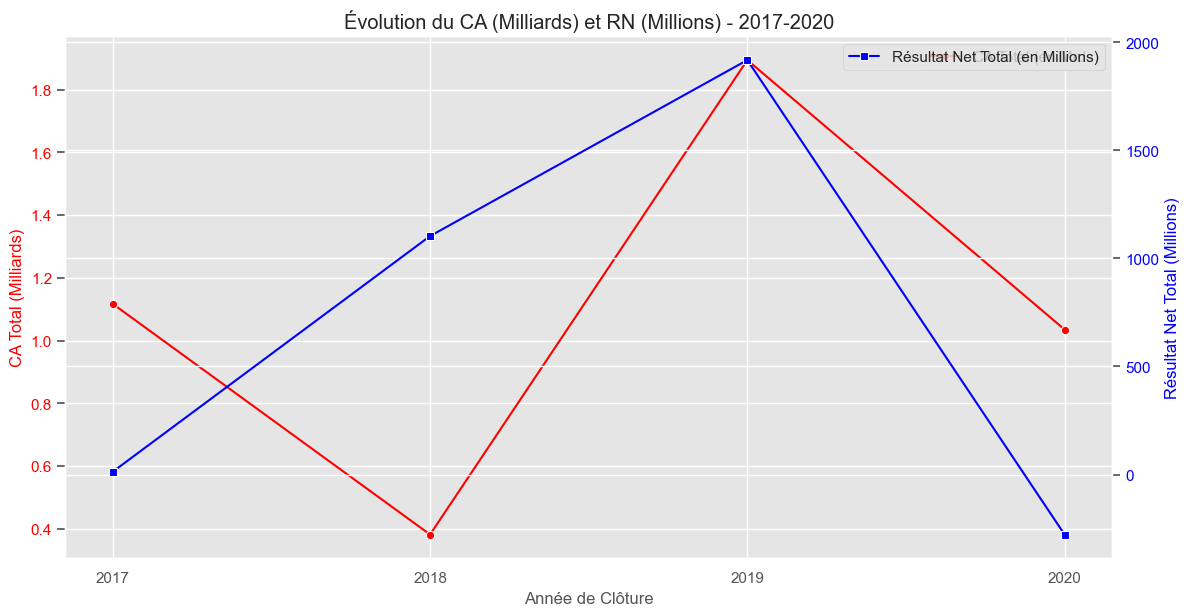

In [25]:
import polars as pl
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Configuration visuelle
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.style.use('ggplot')

# --- 1. Chargement et Préparation des Données ---
FILE_PATH = "../Data/processed/sirene_bilan_EDA.parquet" 

try:
    df_bilan_filtre_pl = pl.read_parquet(FILE_PATH)
except Exception as e:
    print(f"ERREUR CRITIQUE : Impossible de charger le fichier Parquet. Détails: {e}")
    raise

# Assurez-vous d'avoir trié pour les futures étapes de Feature Engineering
df_bilan_filtre_pl = df_bilan_filtre_pl.sort(["siren", "AnneeClotureExercice"]) 

# --- 2. Calcul des Statistiques Globales (Analyse des agrégats BRUTS) ---
stats_globales = df_bilan_filtre_pl.group_by("AnneeClotureExercice").agg([
    pl.count().alias("Nombre_Bilans"),
    pl.col("FA_ChiffreAffairesVentes").sum().alias("CA_Total_BRUT"),
    pl.col("HN_RésultatNet").sum().alias("ResultatNet_Total_BRUT"),
]).sort("AnneeClotureExercice")

stats_globales_pd = stats_globales.to_pandas()

# --- 3. Affichage des Statistiques Brutes pour le Débogage ---
print("--- Statistiques Agrégées BRUTES (Inspection du problème 2017/2020) ---")
print(stats_globales_pd.to_markdown(index=False, floatfmt=".0f"))
print("----------------------------------------------------------------------")
print("SI CA_Total_BRUT est proche de zéro en 2017/2020, il y a un problème de donnée ou de filtrage.")

# --- 4. Visualisation avec Deux Axes Y (Correction de l'échelle) ---

# Mise à l'échelle pour la visualisation : CA en Milliards, RN en Millions
stats_globales_pd['CA_Total_Mrds'] = stats_globales_pd['CA_Total_BRUT'] / 1e9
stats_globales_pd['ResultatNet_Total_Millions'] = stats_globales_pd['ResultatNet_Total_BRUT'] / 1e6

fig, ax1 = plt.subplots(figsize=(12, 6))

# Axe 1 : Chiffre d'Affaires (en Mrds)
sns.lineplot(
    data=stats_globales_pd,
    x='AnneeClotureExercice',
    y='CA_Total_Mrds',
    label='CA Total (en Mrds)',
    marker='o',
    color='red',
    ax=ax1
)
ax1.set_ylabel('CA Total (Milliards)', color='red')
ax1.tick_params(axis='y', labelcolor='red')

# Axe 2 : Résultat Net (en Millions)
ax2 = ax1.twinx() # Création du deuxième axe Y
sns.lineplot(
    data=stats_globales_pd,
    x='AnneeClotureExercice',
    y='ResultatNet_Total_Millions',
    label='Résultat Net Total (en Millions)',
    marker='s',
    color='blue', # Changement de couleur pour la distinction
    ax=ax2
)
ax2.set_ylabel('Résultat Net Total (Millions)', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

# Titre et affichage
fig.tight_layout() # Assure que les étiquettes ne se chevauchent pas
plt.title('Évolution du CA (Milliards) et RN (Millions) - 2017-2020')
ax1.set_xlabel('Année de Clôture')
plt.xticks(stats_globales_pd['AnneeClotureExercice'])
plt.grid(True)
plt.show()

In [16]:
import polars as pl
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Configuration visuelle
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
plt.style.use('ggplot')

# --- 1. Chargement du fichier et Feature Engineering ---
# Simuler le chargement et la conversion de types (important)
# Remplacez "Data/processed/sirene_bilan_EDA.parquet" par votre chemin réel si nécessaire
df_bilan_filtre_pl = pl.read_parquet("../Data/processed/sirene_bilan_EDA.parquet")
# Assurez-vous d'avoir trié pour que shift() fonctionne
df_bilan_filtre_pl = df_bilan_filtre_pl.sort(["siren", "AnneeClotureExercice"]) 


cible_col = "cible_HN_RésultatNet_T_plus_1"

# Application du Feature Engineering (création des colonnes nécessaires à l'analyse)
df_features_pl = df_bilan_filtre_pl.with_columns([
    # Cible Y (Résultat Net à T+1)
    pl.col("HN_RésultatNet").shift(-1).over("siren").alias(cible_col),

    # Deltas (Variation T vs T-1)
    (pl.col("HN_RésultatNet") - pl.col("HN_RésultatNet").shift(1).over("siren")).alias("delta_ResultatNet"),
    (pl.col("FA_ChiffreAffairesVentes") - pl.col("FA_ChiffreAffairesVentes").shift(1).over("siren")).alias("delta_CA"),
    (pl.col("CJCK_TotalActifBrut") - pl.col("CJCK_TotalActifBrut").shift(1).over("siren")).alias("delta_Actif"),
])

# --- 2. Isolation de l'ensemble d'entraînement pour l'EDA ---
# T=2018 (Features) pour Y=2019 (Cible)
df_train_pl = df_features_pl.filter(pl.col("AnneeClotureExercice") == 2018)
df_train_pd = df_train_pl.to_pandas() # Conversion pour les outils de visualisation

stats_cible = df_train_pd[cible_col].describe()
nombre_lignes = df_train_pd.shape[0]

print(f"✅ Dataframe d'entraînement (2018 -> 2019) prêt pour l'EDA. Taille: {nombre_lignes} lignes.")

✅ Dataframe d'entraînement (2018 -> 2019) prêt pour l'EDA. Taille: 286323 lignes.



## 🎯 2. Analyse de la Variable Cible : $	ext{HN\_RésultatNet}$ à $T+1$ (2019)

### 2.1 Statistiques Descriptives

| Statistique | Valeur |
| :--- | :--- |
| **Count (N)** | 286323 |
| **Mean (Moyenne)** | 606713.14 |
| **Std (Écart-type)** | 21471140.51 |
| **Min** | -1750600000.00 |
| **50% (Médiane)** | 8503.00 |
| **Max** | 2147483647.00 |



<>:15: SyntaxWarning: "\_" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\_"? A raw string is also an option.
<>:15: SyntaxWarning: "\_" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\_"? A raw string is also an option.
/var/folders/sp/97__4mlj3nbc2fssvlgn3_nh0000gn/T/ipykernel_43252/2400175961.py:15: SyntaxWarning: "\_" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\_"? A raw string is also an option.
  """


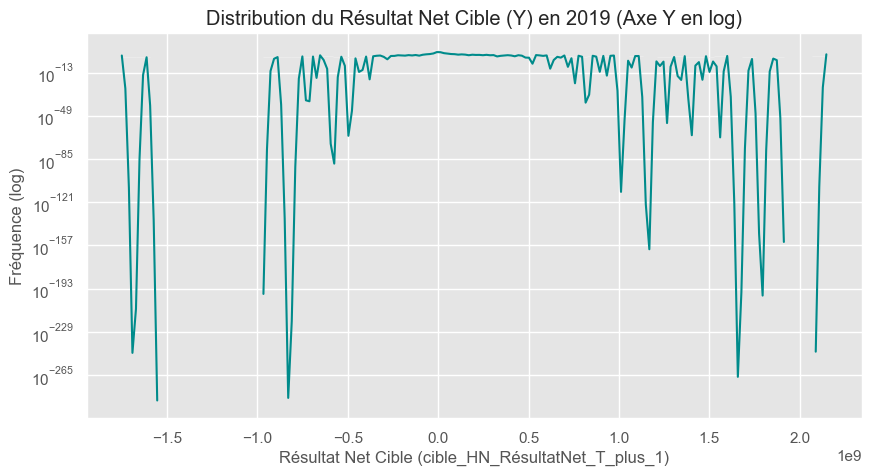

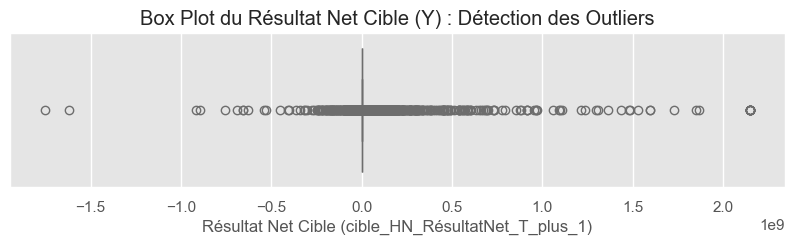

In [17]:
# Markdown pour les Statistiques Descriptives
stats_cible_markdown = f"""
## 🎯 2. Analyse de la Variable Cible : $\text{{HN\_RésultatNet}}$ à $T+1$ (2019)

### 2.1 Statistiques Descriptives

| Statistique | Valeur |
| :--- | :--- |
| **Count (N)** | {stats_cible['count']:.0f} |
| **Mean (Moyenne)** | {stats_cible['mean']:.2f} |
| **Std (Écart-type)** | {stats_cible['std']:.2f} |
| **Min** | {stats_cible['min']:.2f} |
| **50% (Médiane)** | {stats_cible['50%']:.2f} |
| **Max** | {stats_cible['max']:.2f} |
"""
print(stats_cible_markdown)


# 2.2 Distribution et Asymétrie
plt.figure(figsize=(10, 5))
sns.histplot(df_train_pd[cible_col], bins=50, kde=True, color='darkcyan', log_scale=(False, True))
plt.title(f'Distribution du Résultat Net Cible (Y) en 2019 (Axe Y en log)')
plt.xlabel(f'Résultat Net Cible ({cible_col})')
plt.ylabel('Fréquence (log)')
plt.show()


# 2.3 Box Plot pour la détection des Outliers
plt.figure(figsize=(10, 2))
sns.boxplot(x=df_train_pd[cible_col], color='salmon')
plt.title('Box Plot du Résultat Net Cible (Y) : Détection des Outliers')
plt.xlabel(f'Résultat Net Cible ({cible_col})')
plt.show()

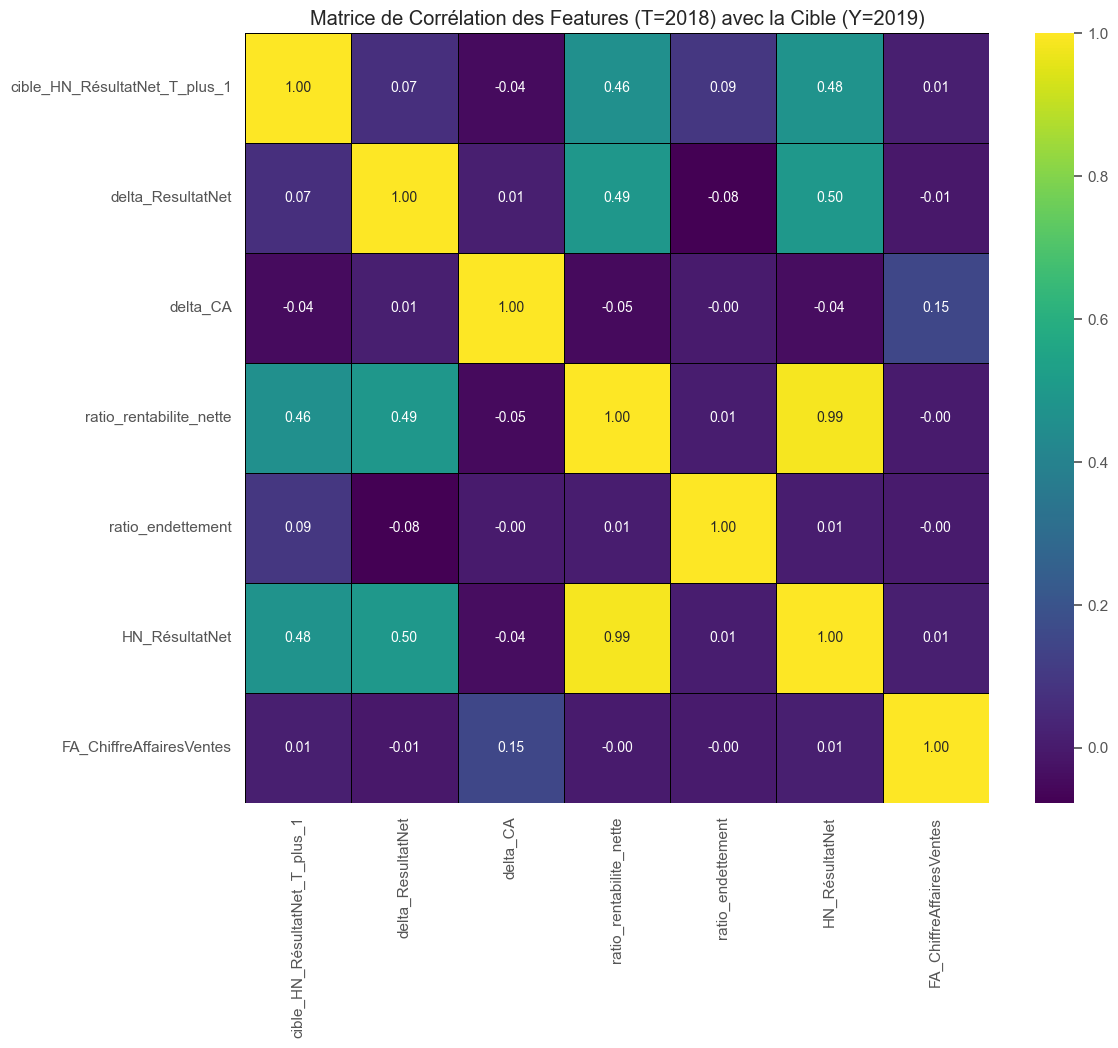

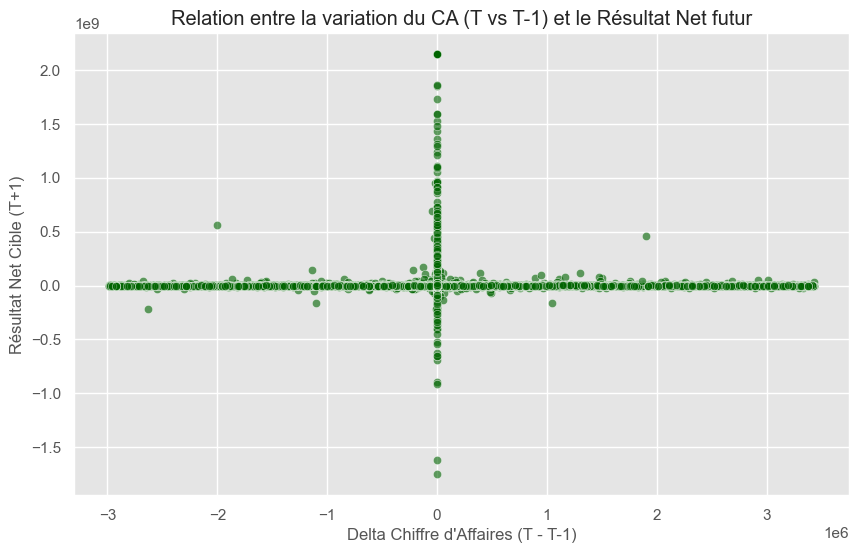

In [18]:
# Définition des colonnes de features clés pour la corrélation
correlation_cols = [cible_col] + [
    "delta_ResultatNet", "delta_CA", "ratio_rentabilite_nette", "ratio_endettement",
    "HN_RésultatNet", "FA_ChiffreAffairesVentes", 
]

# 3.1 Matrice de Corrélation
corr_matrix = df_train_pd[correlation_cols].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='viridis', cbar=True, linewidths=0.5, linecolor='black')
plt.title('Matrice de Corrélation des Features (T=2018) avec la Cible (Y=2019)')
plt.show()


# 3.2 Impact des Deltas (Scatter Plot) - Relation Delta CA vs Cible
plt.figure(figsize=(10, 6))
# Filtrer les 1% extrêmes pour visualiser le cœur de la relation
q_high_ca = df_train_pd['delta_CA'].quantile(0.99)
q_low_ca = df_train_pd['delta_CA'].quantile(0.01)
df_subset_ca = df_train_pd[(df_train_pd['delta_CA'] < q_high_ca) & (df_train_pd['delta_CA'] > q_low_ca)]

sns.scatterplot(x='delta_CA', y=cible_col, data=df_subset_ca, alpha=0.6, color='darkgreen')
plt.title('Relation entre la variation du CA (T vs T-1) et le Résultat Net futur')
plt.xlabel('Delta Chiffre d\'Affaires (T - T-1)')
plt.ylabel('Résultat Net Cible (T+1)')
plt.show()